In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from  sklearn.metrics  import accuracy_score

## Data Exploration

In [77]:
raw_df = pd.read_csv('tweets.csv'); raw_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [80]:
raw_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [76]:
df = raw_df[['text', 'airline_sentiment']]; df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [35]:
df.describe()

,text,airline_sentiment
count,14640,14640
unique,14427,3
top,@united thanks,negative
freq,6,9178


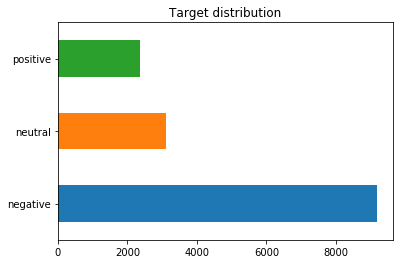

In [73]:
df['airline_sentiment'].value_counts().plot(kind='barh', 
                                            title='Target distribution');
# Note: Dataset is biased toward negative tweets

## Preprocessing

In [48]:
class PreProcessor:
    def __init__(self, df):
        self.data = df
        self.conversations = self.data['text']
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []
        
    def tokenize(self, sentence):
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence
            
    def remove_stopwords(self, sentence):
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https': 
                filtered_sentence.append(w)
        return filtered_sentence
    
    def stem(self, sentence):
        return [self.stemmer.stem(word) for word in sentence]
    
    def join_to_string(self, sentence):
        return ' '.join(sentence)
    
    def full_preprocess(self, n_rows):
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
            
    def list_preprocess(self, n_rows):
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            self.preprocessed.append(stemmed)
            
    def get_data(self):
        return self.preprocessed

In [49]:
preprocessor = PreProcessor(df)
preprocessor.full_preprocess(len(df))
df['cleaned_text'] = preprocessor.get_data()

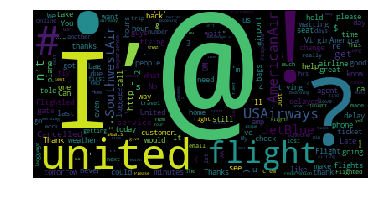

In [34]:
# Visualization
#tokens = word_tokenize(df['text'].str.cat(sep=' '))
#stop_words = set(stopwords.words('english'))
#tokens = [w for w in tokens if not w in stop_words]
#frequency_dist = nltk.FreqDist(tokens)
#from wordcloud import WordCloud
#wordcloud = WordCloud()
#wordcloud.generate_from_frequencies(frequency_dist)
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

## Data transformation (to matrix)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], 
                                                    df['airline_sentiment'], 
                                                    test_size=0.2)

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
print(X_train.shape, X_test.shape)

(11712, 10050) (2928, 10050)


## ML Models

In [58]:
# Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [68]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)
print(f'Accuracy on training set: {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on test set: {round(accuracy_score(y_test,test_pred)*100, 4)}%')

Accuracy on training set: 73.0789%
Accuracy on test set: 70.526%
